In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Exercise 1. 

In [2]:
NUM_EPOCHS = 3
BATCH_SIZE = 128
LEARNING_RATE = 0.005

In [3]:
data_set = datasets.MNIST('./mnist',
                transform=transforms.Compose([
                    transforms.ToTensor(),
#                     transforms.Normalize(0.5, 1),
                ]), 
                download=True)
data_loader = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
def train(model, data_loader, loss_func, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE):
    losses = []
    img_in = []
    img_out = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        step = 0
        for data in data_loader:
            image, _ = data
            image = image.view(image.size(0), -1)
            image = Variable(image)

            if (loss_func == variational_loss):
                output, mu, logvar = model(image)
                loss = loss_func(output, image, mu, logvar)
            else:
                output = model(image)
                loss = loss_func(output, image)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss)

            if step % 100 == 0:
                print('Epoch: ', epoch+1, '; train loss: ', loss.data.numpy())
                img_in.append(image.cpu().data.view(image.size(0), 1, 28, 28))
                img_out.append(output.cpu().data.view(image.size(0), 1, 28, 28))
            
            step += 1
            
    return losses, img_in, img_out

In [44]:
def plot_img(images, title=''):
    fig = plt.figure()
    fig.suptitle(title)
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.axis('off')

In [45]:
def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel('step')
    plt.ylabel('label')
    plt.title('Loss')

In [46]:
def get_compression(x, y):
    print('Compression loss: ', np.around((1-(np.linalg.norm(y) / np.linalg.norm(x)))*100, 3), '%')
#     use bytes instead

## Autoencoder

In [47]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [48]:
auto_encoder = AutoEncoder()
MLE_loss = nn.MSELoss()
losses, img_in, img_out = train(auto_encoder, data_loader, MLE_loss, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)

Epoch:  1 ; train loss:  0.23131683
Epoch:  1 ; train loss:  0.03593557
Epoch:  1 ; train loss:  0.024453616
Epoch:  1 ; train loss:  0.01952365
Epoch:  1 ; train loss:  0.016151205
Epoch:  2 ; train loss:  0.016116656
Epoch:  2 ; train loss:  0.014681065
Epoch:  2 ; train loss:  0.013920156
Epoch:  2 ; train loss:  0.014221914
Epoch:  2 ; train loss:  0.013941941
Epoch:  3 ; train loss:  0.012087603
Epoch:  3 ; train loss:  0.013221054
Epoch:  3 ; train loss:  0.012741428
Epoch:  3 ; train loss:  0.012555018
Epoch:  3 ; train loss:  0.011320968


Compression loss:  2.011 %


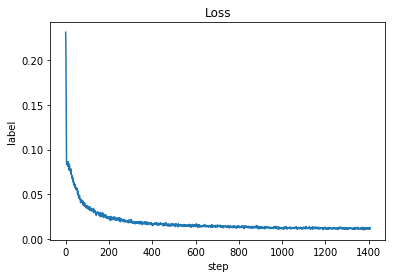

In [49]:
plot_loss(losses)
get_compression(img_in[-1], img_out[-1])

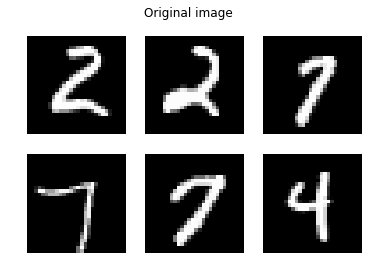

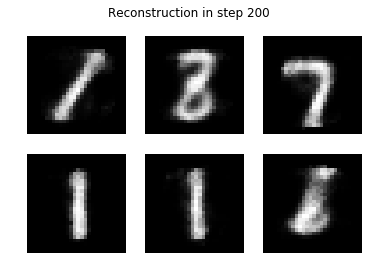

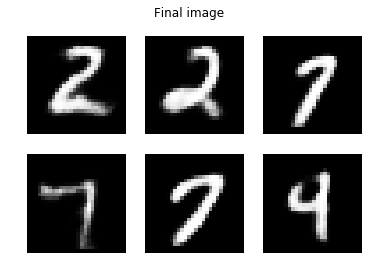

In [50]:
plot_img(img_in[-1][:7], 'Original image')
plot_img(img_out[1][:7], 'Reconstruction in step 200')
plot_img(img_out[-1][:7], 'Final image')

## Variational Autoencoder

In [51]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(True),
            nn.Linear(400, 40))
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(True),
            nn.Linear(400, 28*28),
            nn.Sigmoid())
        
    def var_parameters(self, mu, logvar):
        var = logvar.exp()
        std = var.sqrt()
        eps = Variable(torch.FloatTensor(std.size()).normal_())
        return eps.mul(std).add(mu)
    
    def forward(self, x):
        h = self.encoder(x)
        
        mu = h[:, :20]
        logvar = h[:, 20:]
        
        z = self.var_parameters(mu, logvar)
        y = self.decoder(z)
        return y, mu, logvar

In [52]:
def variational_loss(y, x, mu, logvar):
    BCE = nn.BCELoss()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)-logvar.exp())
    KLD /= BATCH_SIZE * 784 #748=28*28
    return BCE(y, x) + KLD

In [55]:
v_auto_encoder = VariationalAutoEncoder()
losses, img_in, img_out = train(v_auto_encoder, data_loader, variational_loss, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)

Epoch:  1 ; train loss:  0.702724
Epoch:  1 ; train loss:  0.18765771
Epoch:  1 ; train loss:  0.16585928
Epoch:  1 ; train loss:  0.16573653
Epoch:  1 ; train loss:  0.14877649
Epoch:  2 ; train loss:  0.14732493
Epoch:  2 ; train loss:  0.14876632
Epoch:  2 ; train loss:  0.14288095
Epoch:  2 ; train loss:  0.15035398
Epoch:  2 ; train loss:  0.14260441
Epoch:  3 ; train loss:  0.1386847
Epoch:  3 ; train loss:  0.14358006
Epoch:  3 ; train loss:  0.1401333
Epoch:  3 ; train loss:  0.14491081
Epoch:  3 ; train loss:  0.14456584


Compression loss:  8.525 %


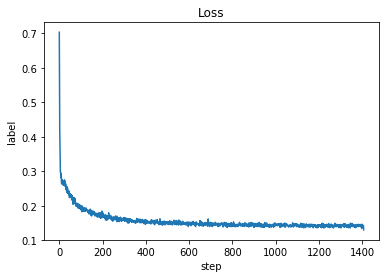

In [56]:
plot_loss(losses)
get_compression(img_in[-1], img_out[-1])

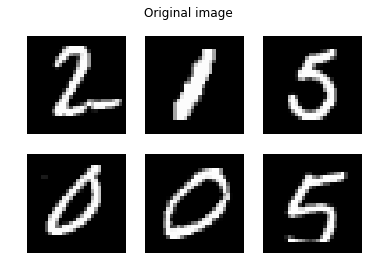

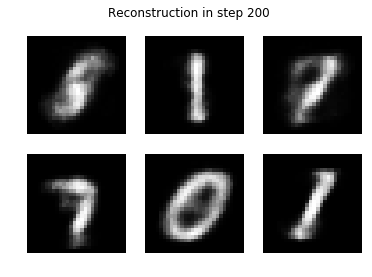

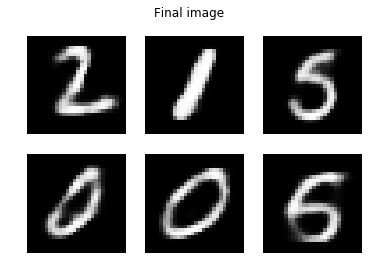

In [57]:
plot_img(img_in[-1][:7], 'Original image')
plot_img(img_out[1][:7], 'Reconstruction in step 200')
plot_img(img_out[-1][:7], 'Final image')

In [58]:
def generate_image():
    pass